In [13]:
import os
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import shap

%run ../../helper/preprocess.py
%run ../../helper/aggregate.py
%run ../../helper/utils.py
%run shap_analysis.py

shap.initjs()
matplotlib.rcParams['pdf.fonttype'] = 42
sns.set(font_scale=1.6)
sns.set_style("white")

In [2]:
metrics_file = '../../metrics/ddim_sd15_metrics.csv'
config_file = '../../../exp_configs/config_mapping.csv'

keywords_to_exclude = ['1027', '1007', '1017', ]
# keywords_to_exclude = []

metrics_processed = load_and_preprocess_metrics(
    metrics_file,
    config_file,
    rank=True,
    metrics_to_include=None,
    keywords_to_exclude=keywords_to_exclude)

In [3]:
keywords_to_exclude = ['1003', '1013', '1023']
metrics_processed = metrics_processed[metrics_processed['Config'].apply(
    lambda x: not any(keyword in x for keyword in keywords_to_exclude))]
print(metrics_processed.shape)

(8073, 80)


In [61]:
8424/39/9

24.0

## Per category: People

In [4]:
category = 'people'

metrics_aggregated = aggregate_metrics(
    metrics_processed[metrics_processed['Category'] == category],
    level='All',
    group_seeds=False)
print(metrics_aggregated.shape)

(207, 143)


In [5]:
metric_types = ['Image Similarity', 'Text Similarity', 'Vendi']
encoders = ['DINOv2', 'CLIP', 'DINOv2', 'Vgg19']
modes = ['padding']
prompt_types = ['in', 'trigger', 'out']

metrics_to_include = get_metric_list(metric_types, encoders, modes,
                                     prompt_types, style_with_base_model=False)

In [6]:
del metrics_to_include[3]
del metrics_to_include[3]
del metrics_to_include[4]
metrics_to_include.append(('Style Loss', 'Vgg19', 'base model'))

In [7]:
metrics_to_include

[('Image Similarity', 'DINOv2-padding', 'in'),
 ('Image Similarity', 'DINOv2-padding', 'trigger'),
 ('Image Similarity', 'DINOv2-padding', 'out'),
 ('Text Similarity', 'CLIP', 'out'),
 ('Vendi', 'DINOv2', 'trigger'),
 ('Vendi', 'DINOv2', 'out'),
 ('Style Loss', 'Vgg19', 'base model')]

In [8]:
analysis = FeatureAnalysis(metrics_aggregated, keyword=category)
analysis.fit(metrics_to_include, test_size=None)
analysis.transform_nt()

Fitting ('Image Similarity', 'DINOv2-padding', 'in')
Training performance
RMSE: 0.09
R2: 0.78
Fitting ('Image Similarity', 'DINOv2-padding', 'trigger')
Training performance
RMSE: 0.08
R2: 0.88
Fitting ('Image Similarity', 'DINOv2-padding', 'out')
Training performance
RMSE: 0.10
R2: 0.82
Fitting ('Text Similarity', 'CLIP', 'out')
Training performance
RMSE: 0.10
R2: 0.85
Fitting ('Vendi', 'DINOv2', 'trigger')
Training performance
RMSE: 0.09
R2: 0.73
Fitting ('Vendi', 'DINOv2', 'out')
Training performance
RMSE: 0.11
R2: 0.60
Fitting ('Style Loss', 'Vgg19', 'base model')
Training performance
RMSE: 0.13
R2: 0.54


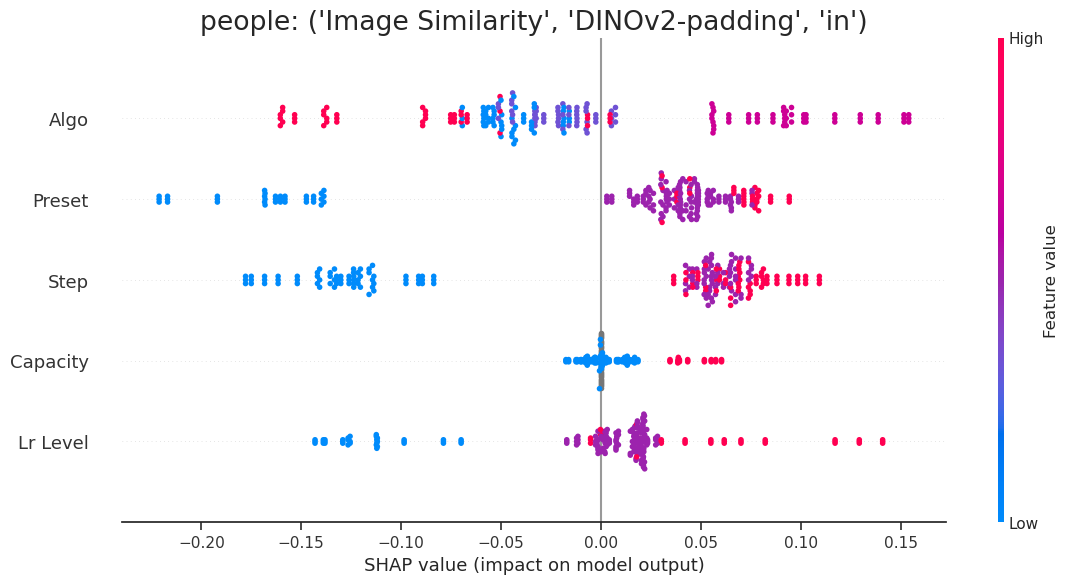

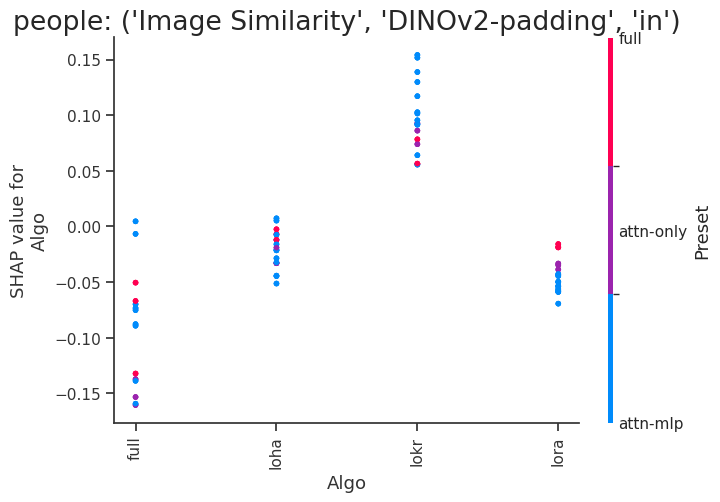

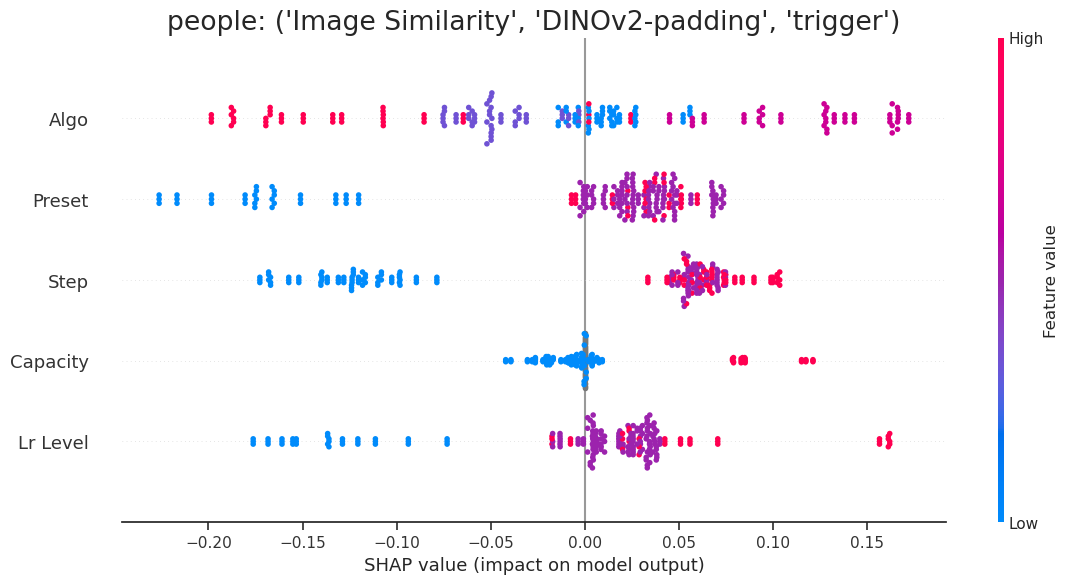

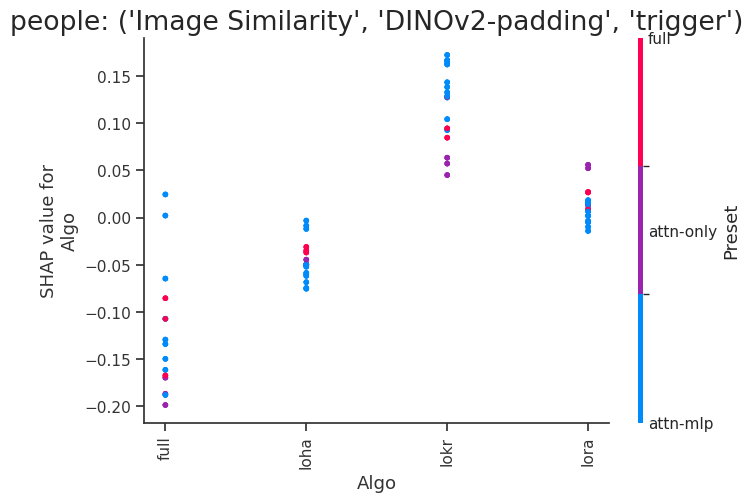

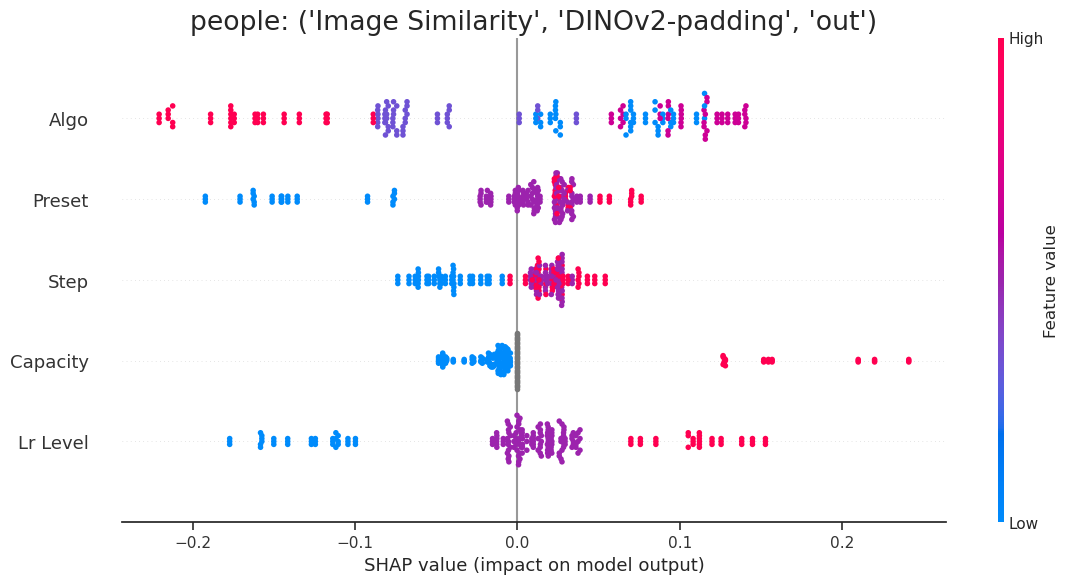

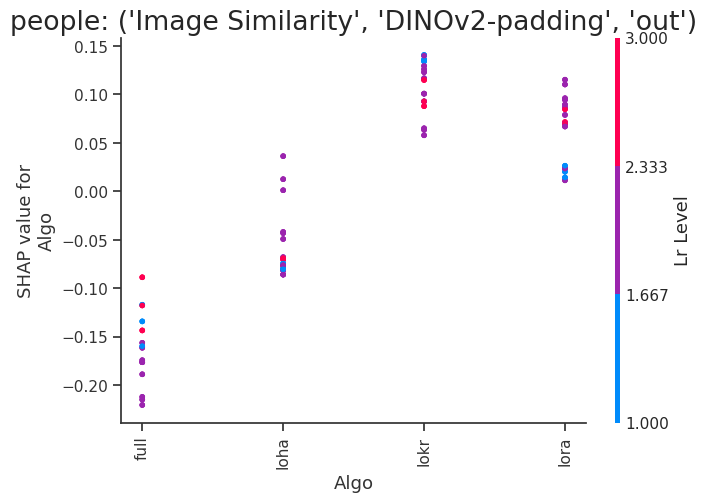

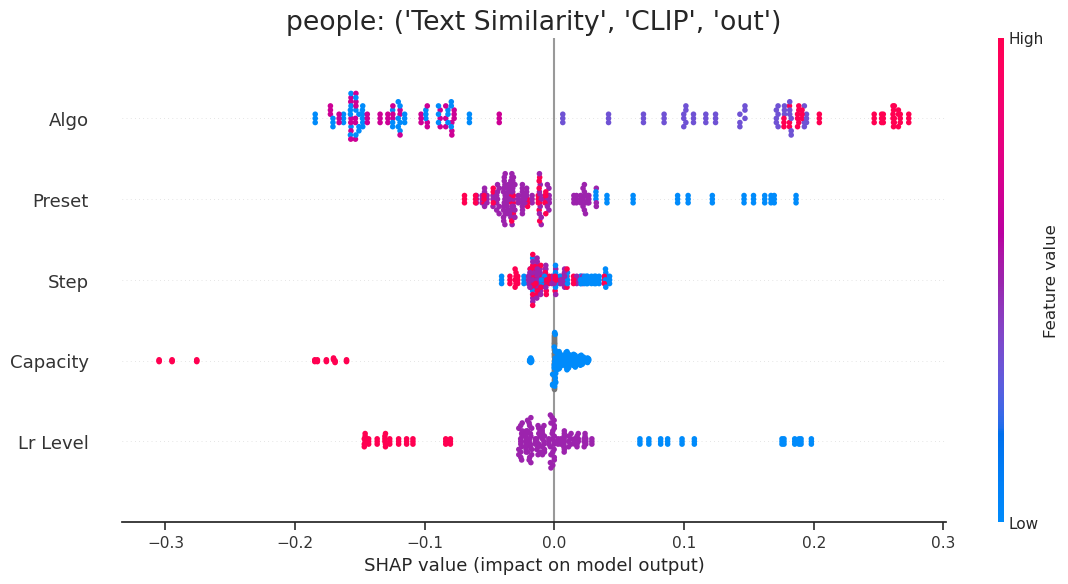

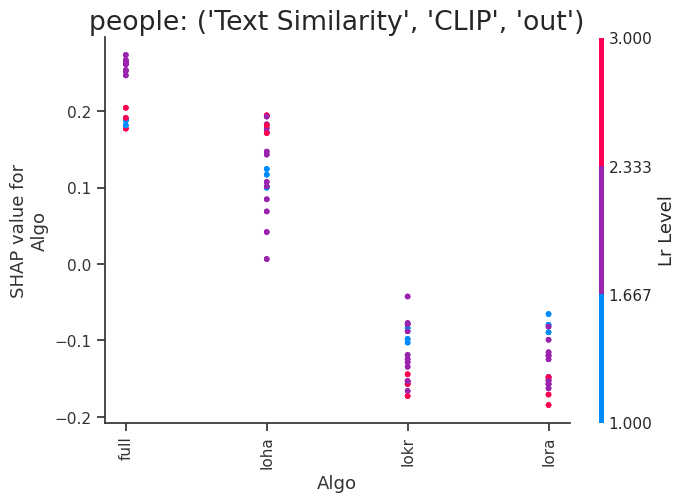

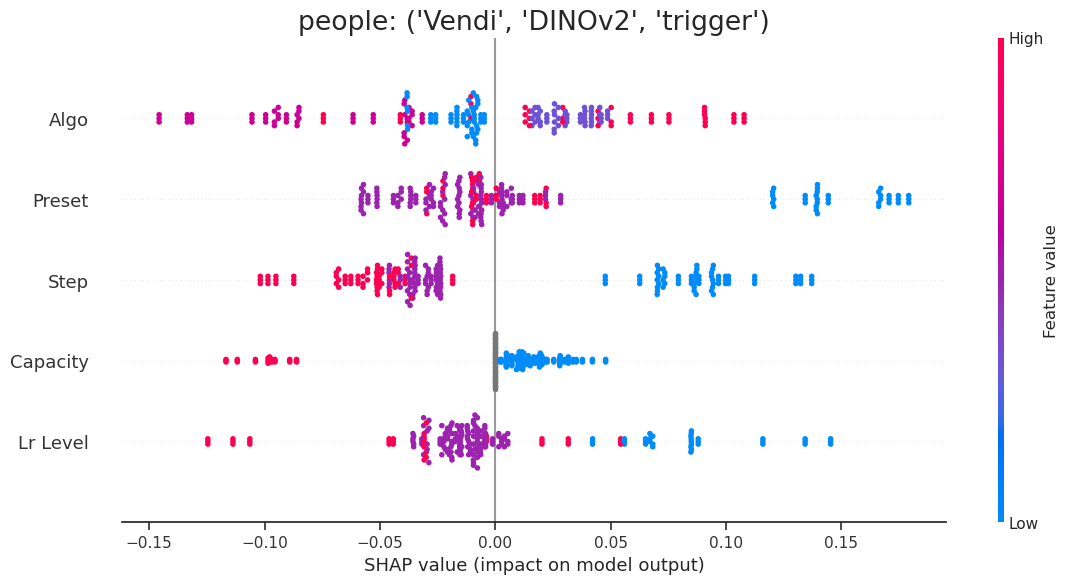

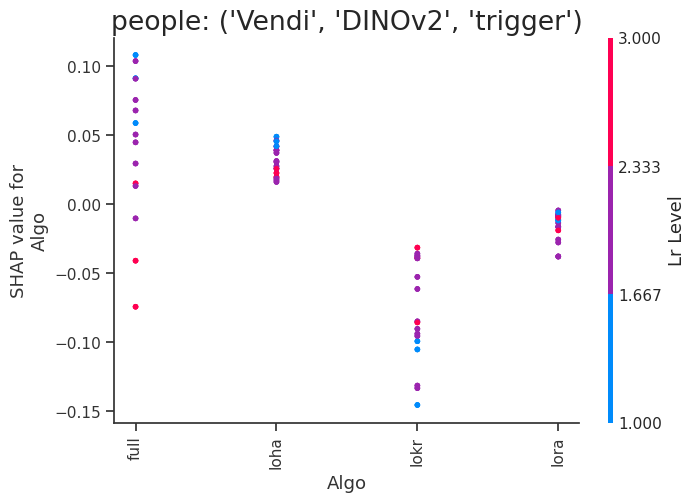

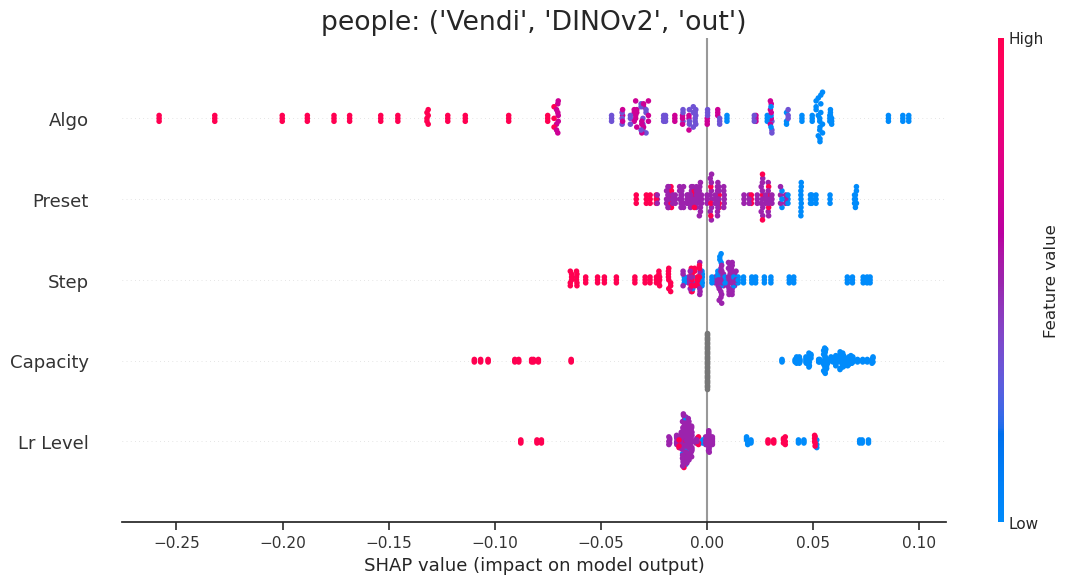

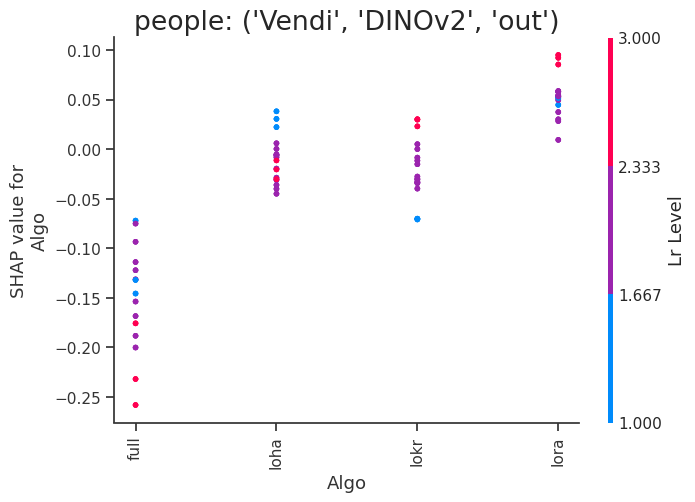

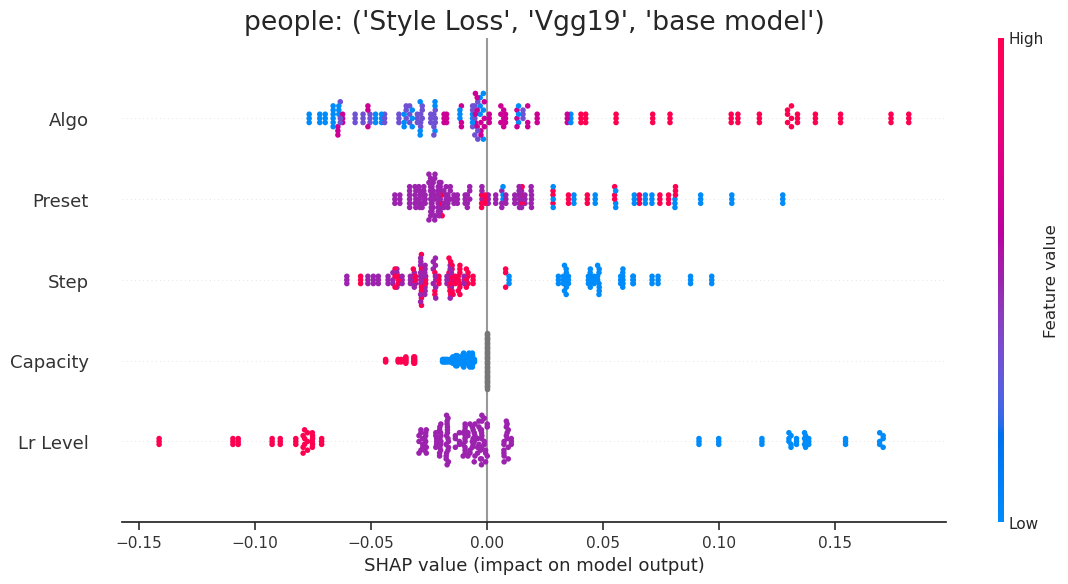

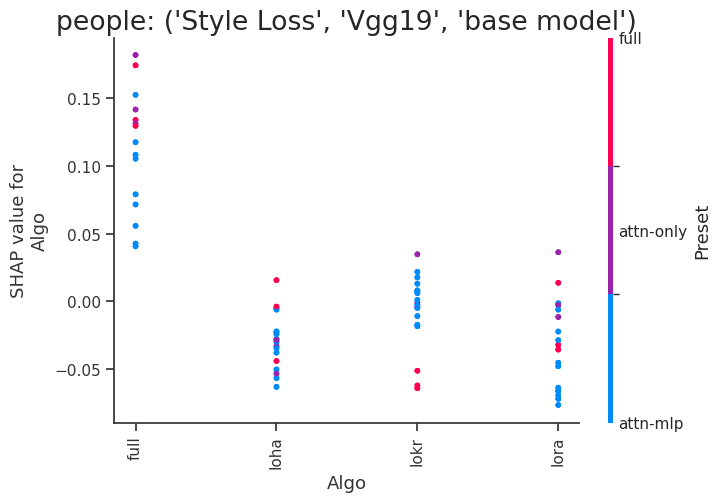

In [14]:
shap_values_list = []

for metric in metrics_to_include:
    plt.figure(figsize=(10, 8))
    shap_values = analysis.models[metric]['shap_values']
    shap.summary_plot(shap_values,
                      analysis.X_for_plot,
                      show=False,
                      plot_size=(12, 6),
                      sort=False)
    shap_values_list.append(shap_values)
    plt.title(f"{category}: {metric}")
    save_dir = f"figures/{metric}"
    os.makedirs(save_dir, exist_ok=True)
    plt.savefig(os.path.join(save_dir, f"{category}_{metric}_shap.png"))

    shap.dependence_plot(
        "Algo",
        shap_values,
        analysis.X,
        show=False,
    )
    plt.title(f"{category}: {metric}")
    save_dir = f"figures/dependence/{metric}"
    os.makedirs(save_dir, exist_ok=True)
    plt.savefig(os.path.join(save_dir, f"{category}_{metric}_shap.png"))

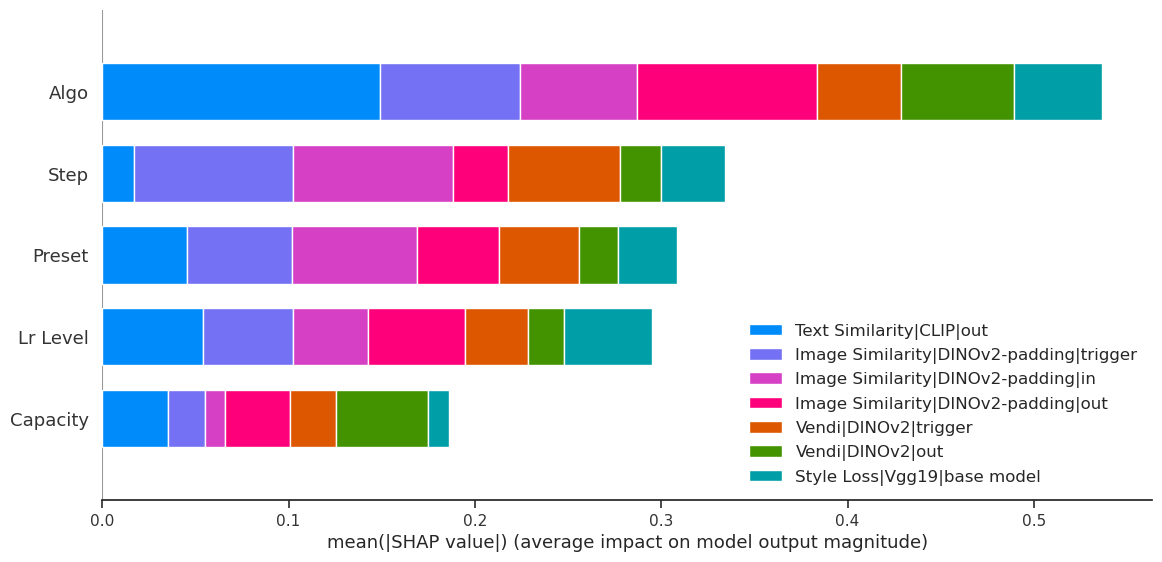

In [73]:
plt.figure(figsize=(20, 12))

shap.summary_plot(
    shap_values_list,
    analysis.X_for_plot,
    plot_type="bar",
    class_names=['|'.join(parts) for parts in metrics_to_include],
    feature_names=analysis.X_for_plot.columns,
    plot_size=(12, 6),
    show=False)
plt.savefig(
    f"figures/{category}_{metric}_shap_feature_importance.png"
)